In [1]:
# Import PyTorch and related libraries
import torch  # Core PyTorch library
import torch.nn as nn  # Neural network module for defining layers and loss functions
import torch.optim as optim  # Optimization algorithms, such as Adam, SGD
import torch.autograd as autograd  # Autograd module for automatic differentiation

# Determine the device to use: GPU if available, otherwise CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Import libraries for plotting and numerical operations
import matplotlib.pyplot as plt  # Plotting library for visualizing results
import numpy as np  # Numerical operations, especially for array handling


In [2]:
class HeatEquationNN(nn.Module):
    def __init__(self, layers):
        # Initialize the base class for neural network modules
        super(HeatEquationNN, self).__init__()

        # Define the activation function to be used in the hidden layers (Tanh in this case)
        # Other activation functions like SiLU, Sigmoid, Swish, and ReLU are commented out but could be used instead
        self.activation = nn.Tanh()

        # Create a list of linear layers based on the sizes specified in 'layers'
        # Each Linear module connects two layers of the neural network
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])

        # Save the layer architecture for reference
        self.layers = layers

        # Initialize the weights and biases of each layer
        # Xavier initialization for weights and zeros for biases to promote better training dynamics
        for i in range(len(self.layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)

    def forward(self, x):
        # Check if the input 'x' is a tensor; if not, convert it from a numpy array
        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)

        # Convert input data to float type for compatibility with PyTorch layers
        a = x.float()

        # Forward propagation through the network
        # Apply each linear layer followed by the activation function, except for the last layer
        for i in range(len(self.layers)-2):
            z = self.linears[i](a)   # Apply linear transformation
            a = self.activation(z)   # Apply activation function

        # The last layer does not have an activation function
        a = self.linears[-1](a)

        # Return the output of the network
        return a

    #===========================================================
    
    def lossBC(self, p_bc1, p_bc2):
        # Compute boundary condition loss for points p_bc1 and p_bc2

        # Clone and set requires_grad=True to compute gradients
        g1 = p_bc1.clone()
        g1.requires_grad = True
        u1 = self.forward(g1)  # Forward pass for the first set of boundary points
        
        g2 = p_bc2.clone()
        g2.requires_grad = True
        u2 = self.forward(g2)  # Forward pass for the second set of boundary points

        # Calculate the boundary condition residuals
        Bc_1 = u1 - 60  # Assuming boundary condition u=60 for p_bc1
        Bc_2 = u2 - 60  # Assuming boundary condition u=60 for p_bc2

        # Calculate the mean squared error for the boundary conditions
        L_bc = torch.mean(Bc_1**2) + torch.mean(Bc_2**2)

        # Return the boundary condition loss
        return L_bc

    #-----------------------------------------------------------
    
    def lossIC(self, p_ic):
        # Compute initial condition loss for points p_ic

        # Clone and set requires_grad=True to compute gradients
        g_ic = p_ic.clone()
        g_ic.requires_grad = True
        u_ic = self.forward(g_ic)  # Forward pass for initial condition points
        
        # Calculate the initial condition residual
        f_ic = u_ic - 50  # Assuming initial condition u=50

        # Calculate the mean squared error for the initial condition
        L_ic = torch.mean(f_ic**2)

        # Return the initial condition loss
        return L_ic

    #------------------------------------------------------    
    def lossPDE(self, p_grid):
        # Compute PDE loss over the grid points p_grid

        # Clone and set requires_grad=True to compute gradients
        g_gr = p_grid.clone()
        g_gr.requires_grad = True
        u = self.forward(g_gr)  # Forward pass for grid points

        # Compute gradients of u with respect to the grid points
        du = autograd.grad(u, g_gr, torch.ones(u.shape[0],1).to(device), retain_graph=True, create_graph=True)[0]
        u_x = du[:, 0].unsqueeze(1)  # Spatial derivative
        u_t = du[:, 1]               # Temporal derivative

        # Compute second-order spatial derivative
        du_x = autograd.grad(u_x, g_gr, torch.ones(u_x.shape[0],1).to(device), retain_graph=True, create_graph=True)[0]
        u_xx = du_x[:, 0]

        # Calculate the PDE residual using the heat equation (u_t = alpha * u_xx)
        pde = u_t - alpha * u_xx

        # Calculate the mean squared error for the PDE
        L_pde = torch.mean(pde**2)

        # Return the PDE loss
        return L_pde

    #============================================================
    def loss(self, p_grid, p_bc1, p_bc2, p_ic):
        # Calculate the total loss as a combination of the boundary, initial, and PDE losses

        loss_bc = self.lossBC(p_bc1, p_bc2)  # Boundary condition loss
        loss_ic = self.lossIC(p_ic)          # Initial condition loss
        loss_pde = self.lossPDE(p_grid)      # PDE loss

        # Return the individual losses for further analysis or optimization
        return loss_bc, loss_ic, loss_pde


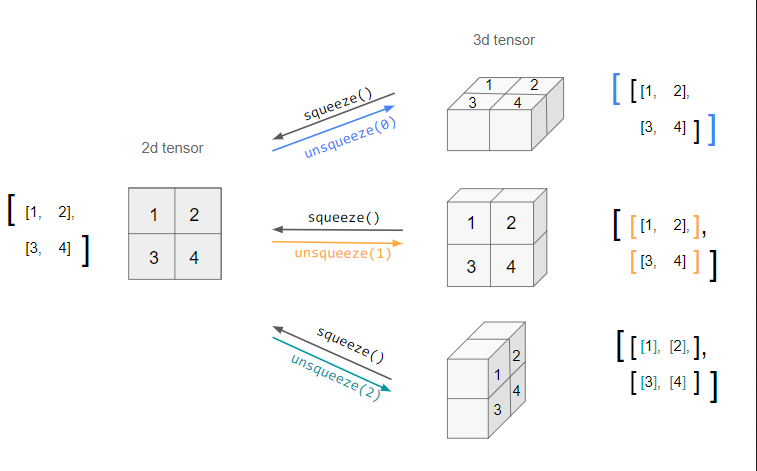

In [3]:
def new_grid(Nc, Nbc, Nic, xmin, xmax,tmax):
    """
    Generates a new grid of points for training a Physics-Informed Neural Network (PINN) to solve the 
    heat equation.

    Parameters:
    Nc (int): Number of collocation points for the PDE.
    Nbc (int): Number of boundary condition points.
    Nic (int): Number of initial condition points.
    xmin (float): Minimum x-coordinate value.
    xmax (float): Maximum x-coordinate value.
    tmax (float): Maximum t-coordinate value.
    
    Returns:
    tuple: Contains grid points for the PDE (grid), boundary condition points (bc1, bc2) and 
    initial condition points (ic_points).
    """

    # Generate collocation points for the PDE 
    grid = torch.zeros(Nc,2)                      # Create a tensor of zeros with shape (Nc, 2)
    grid[:,0] = xmin + (xmax-xmin)*torch.rand(Nc) # Randomly generate x-coordinates in the range [xmin, xmax]
    grid[:,1] = torch.rand(Nc)*tmax               # Randomly generate t-coordinates in the range [0, tmax]
    grid = grid.to(device)              # Move the tensor to the specified device (GPU)

    #=========================
    
    # Generate boundary condition points for the left boundary (x = minx)
    bc1 = torch.zeros(Nbc, 2)           # Create a tensor of zeros with shape (Nbc, 2)
    bc1[:, 0] = xmin                    # Set all x-coordinates to minx (left boundary)
    bc1[:, 1] = torch.rand(Nbc) * tmax  # Randomly generate t-coordinates in the range [0, tmax]
    bc1 = bc1.to(device)                # Move the tensor to the specified device (GPU)

    #---------------------
    
    # Generate boundary condition points for the right boundary (x = maxx)
    bc2 = torch.zeros(Nbc, 2)           # Create a tensor of zeros with shape (Nbc, 2)
    bc2[:, 0] = xmax                    # Set all x-coordinates to maxx (right boundary)
    bc2[:, 1] = torch.rand(Nbc) * tmax  # Randomly generate t-coordinates in the range [0, tmax]
    bc2 = bc2.to(device)                # Move the tensor to the specified device (GPU)

    #---------------------
    
    # Generate initial condition points at t = 0 across the spatial domain [minx, maxx]
    ic_points = torch.zeros(Nic, 2)  # Create a tensor of zeros with shape (Nic, 2)
    ic_points[:, 0] = xmin + (xmax-xmin)*torch.rand(Nic)  # Randomly generate x-coordinates in the range [minx, maxx]
    ic_points = ic_points.to(device)  # Move the tensor to the specified device (GPU)
   
    # Return the generated points for the grid, boundary conditions, and initial conditions
    return grid, bc1, bc2, ic_points


In [4]:
def loss_plot(Loss_plt, l_pde, l_bc, l_ic):
    """
    Plots the loss functions during the training of a Physics-Informed Neural Network (PINN).

    Parameters:
    Loss_plt (list or ndarray): The total loss values recorded over epochs.
    l_pde (list or ndarray): The loss values related to the PDE constraint over epochs.
    l_bc (list or ndarray): The loss values related to the boundary conditions over epochs.
    l_ic (list or ndarray): The loss values related to the initial conditions over epochs.
    """
    
    # Plot the total loss over epochs
    plt.plot(Loss_plt, label='Total')
    
    # Plot the PDE loss over epochs
    plt.plot(l_pde, label='PDE')
    
    # Plot the boundary condition loss over epochs
    plt.plot(l_bc, label='BC')
    
    # Plot the initial condition loss over epochs
    plt.plot(l_ic, label='IC')
    
    # Update the plot parameters for better visualization
    plt.rcParams.update({'font.size': 15})  # Set the font size for the plot text
    plt.title('Loss functions')             # Set the title of the plot
    plt.xlabel('epochs')                    # Set the label for the x-axis
    plt.yscale("log")                       # Set the y-axis to a logarithmic scale for better visualization of losses that span several orders of magnitude
    
    # Add grid lines to the plot for better readability
    plt.grid()
    
    # Format the x-axis labels using scientific notation
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,4))
    
    # Display the legend to distinguish between different loss curves
    plt.legend()
    
    # Display the plot
    plt.show()


In [18]:
# Define the architecture of the neural network
layers = [2,32,32,32, 1]  # List defining the number of neurons in each layer; [input_dim, hidden_layer1,
                             # hidden_layer2, hidden_layer3, output_dim]

# Instantiate the HeatEquationNN model with the specified architecture
PINN = HeatEquationNN(layers)

# Move the model to the specified device (GPU)
PINN.to(device)

# Define the optimizer for training the model
optimizer = optim.Adam(PINN.parameters(), lr=0.001)  # Adam optimizer is used with a learning rate of 0.001

# Initialize lists to store the loss values over training epochs for plotting purposes
Loss_plt  = []  # List to store the total loss at each epoch
l_plt_pde = []  # List to store the PDE loss at each epoch
l_plt_bc  = []  # List to store the boundary condition (BC) loss at each epoch
l_plt_ic  = []  # List to store the initial condition (IC) loss at each epoch


Training start!
epoch =  2000


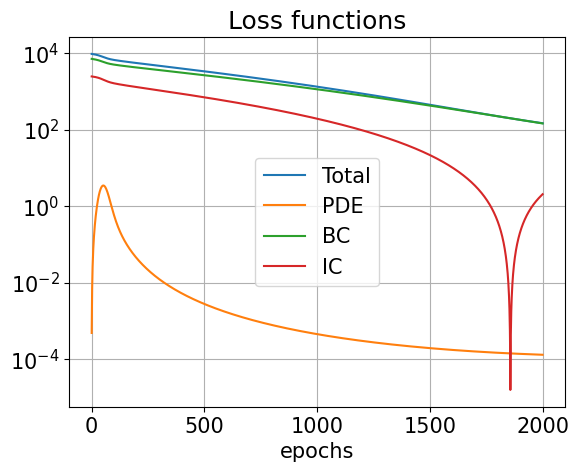

epoch =  4000


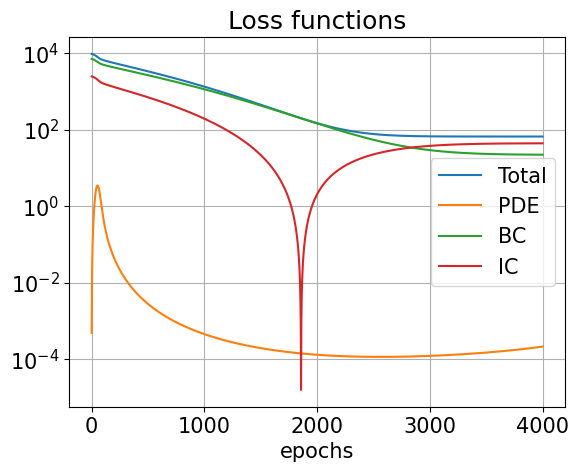

New Grid
epoch =  6000


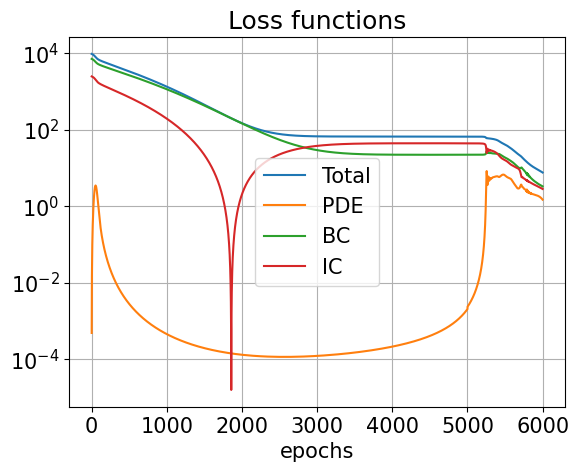

epoch =  8000


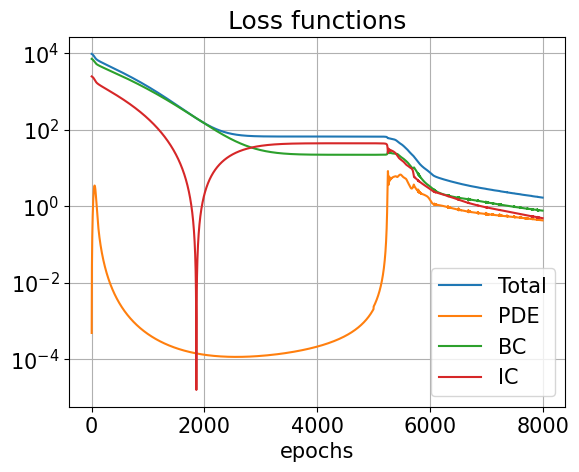

epoch =  10000


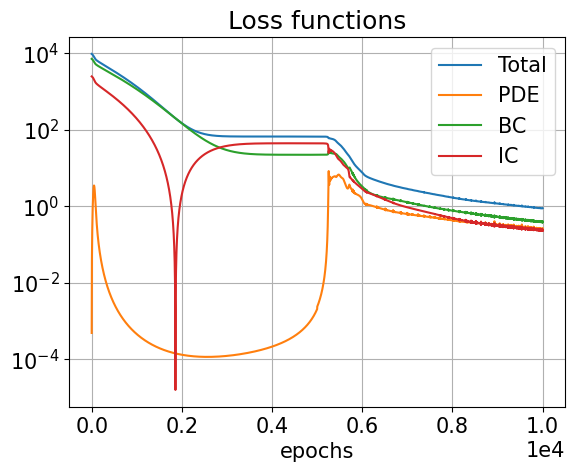

New Grid
epoch =  12000


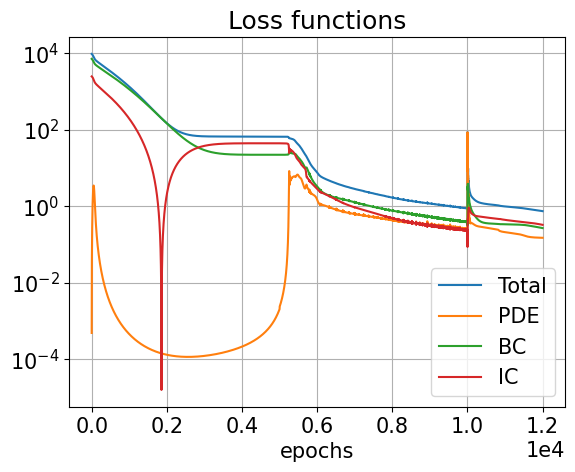

epoch =  14000


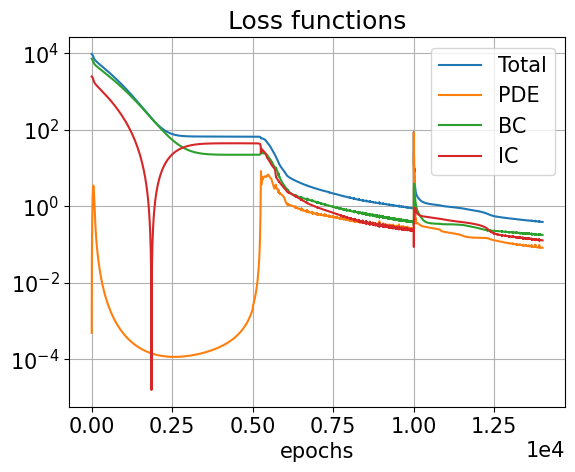

New Grid
epoch =  16000


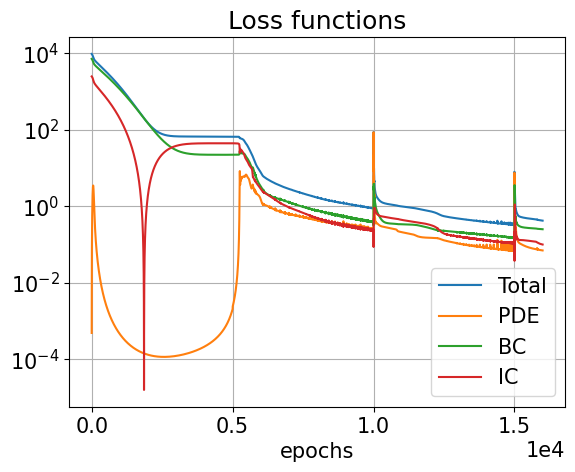

epoch =  18000


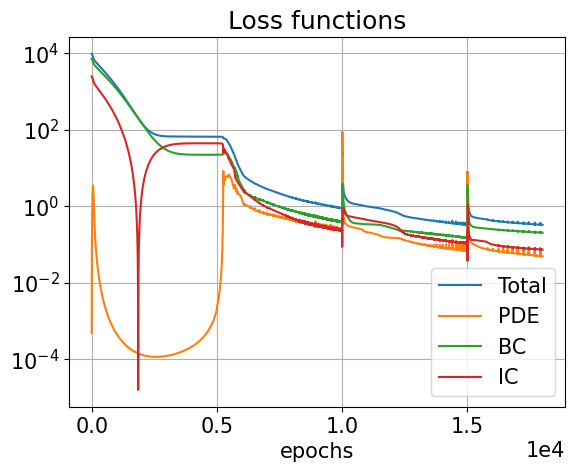

epoch =  19999


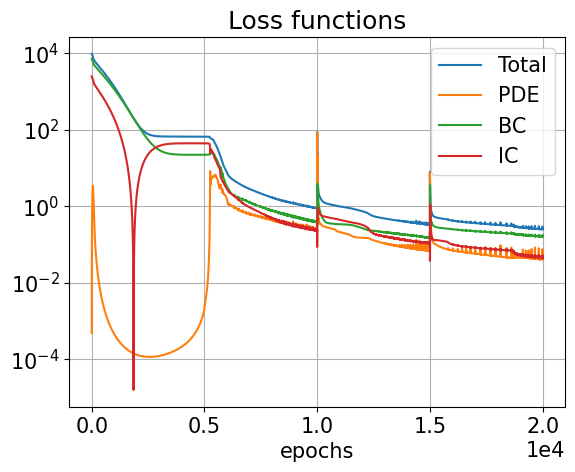

In [19]:
# Set parameters for the heat equation and training process
alpha = 0.1                 # Thermal diffusivity constant for the heat equation
epochs = 20000              # Total number of training epochs
w1 = 1e0                    # Weight for the boundary condition loss (bc)
w2 = 1e0                    # Weight for the initial condition loss (ic)
w3 = 1e0                    # Weight for the PDE loss (pde)

# Set parameters for data generation
Nc  = 1000                  # Number of collocation points for the PDE
Nbc = 1000                  # Number of boundary condition points
Nic = 1000                  # Number of initial condition points
H = 0.5                     # Spatial domain parameter
xmin = 0                    # Minimum x-value 
xmax = 2 * H                # Maximum x-value 
tmax = 1                    # Maximum t_value 

# Generate the initial grid and condition points using the new_grid function
grid, bc1, bc2, ic_points = new_grid(Nc, Nbc, Nic, xmin, xmax, tmax)

# Training loop
print('Training start!')
for epoch in range(epochs):
    
    # Calculate the individual losses for boundary conditions (l_bc), initial conditions (l_ic), and PDE (l_pde)
    l_bc, l_ic, l_pde = PINN.loss(grid, bc1, bc2, ic_points)
    
    # Compute the weighted sum of the losses to get the total loss
    loss = w1 * l_bc + w2 * l_ic + w3 * l_pde
    
    # Reset the gradients of the optimizer to zero
    optimizer.zero_grad()
    
    # Backpropagate the loss to compute the gradients
    loss.backward()
    
    # Update the model parameters based on the computed gradients
    optimizer.step()
    
    # Record the loss values for plotting and analysis
    Loss_plt.append(l_pde.item() + l_bc.item() + l_ic.item())  # Total loss
    l_plt_pde.append(l_pde.item())  # PDE loss
    l_plt_bc.append(l_bc.item())    # Boundary condition loss
    l_plt_ic.append(l_ic.item())    # Initial condition loss
    
    # Plot the loss curves every 2000 epochs
    if epoch > 0 and epoch % 2000 == 0:
        print('epoch = ', epoch)
        loss_plot(Loss_plt, l_plt_pde, l_plt_bc, l_plt_ic)
    
    # Regenerate a new grid of points every 5000 epochs to provide fresh data
    if epoch > 0 and epoch % 5000 == 0:
        grid, bc1, bc2, ic_points  = new_grid(Nc, Nbc, Nic, xmin, xmax, tmax)
        print('New Grid')

# Final output after training
print('epoch = ', epoch)
loss_plot(Loss_plt, l_plt_pde, l_plt_bc, l_plt_ic)


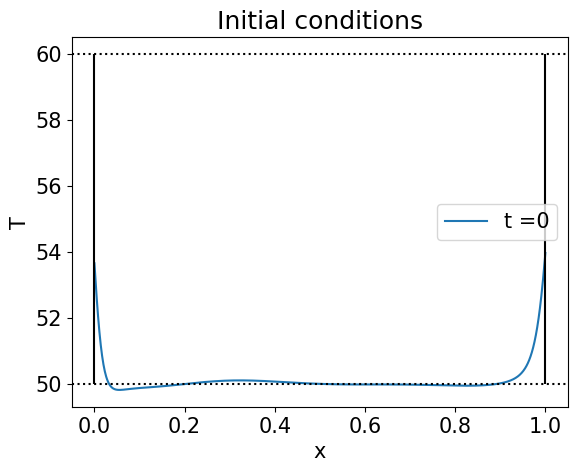

In [9]:
# Define the number of points and initial time for plotting
n_points = 1000              # Number of points to sample for plotting the initial condition
t0 = 0                      # Initial time for which we are plotting the initial condition

# Create a tensor to hold the points for plotting the initial condition
points_ic_plot = torch.zeros(n_points, 2)  # Tensor of shape (n_points, 2) to store x and t values

# Fill the tensor with x values evenly spaced between minx and maxx, and set all t values to t0
points_ic_plot[:, 0] = torch.linspace(xmin, xmax, n_points)  # x values from minx to maxx
points_ic_plot[:, 1] = t0  # All t values set to t0

# Pass the points through the neural network to get the predicted temperature values at the initial time
F_x_0 = PINN(points_ic_plot.to(device)).cpu()  # Predictions from the PINN model, moved back to CPU
x_0 = points_ic_plot[:, 0]  # Extract the x values from the tensor

# Plot the predicted temperature at the initial time
plt.plot(x_0.detach().numpy(), F_x_0.detach().numpy(), label='t =' + str(t0))
# Convert tensors to numpy arrays for plotting and label the curve with the initial time

# Add horizontal lines to indicate the bounds of the initial temperature
plt.axhline(y=50, xmin=xmin, xmax=xmax, linestyle='dotted', color='black')  # Horizontal line at y=50
plt.axhline(y=60, xmin=xmin, xmax=xmax, linestyle='dotted', color='black')  # Horizontal line at y=60

# Add vertical lines to indicate the boundaries of the spatial domain
plt.vlines(x=xmin, ymin=50, ymax=60, colors='black')  # Vertical line at x=minx
plt.vlines(x=xmax, ymin=50, ymax=60, colors='black')  # Vertical line at x=maxx

# Add labels, title, and legend to the plot
plt.legend()                 # Display the legend for the plot
plt.title('Initial conditions')  # Set the title of the plot
plt.xlabel('x')             # Label the x-axis
plt.ylabel('T')             # Label the y-axis

# Show the plot
plt.show()


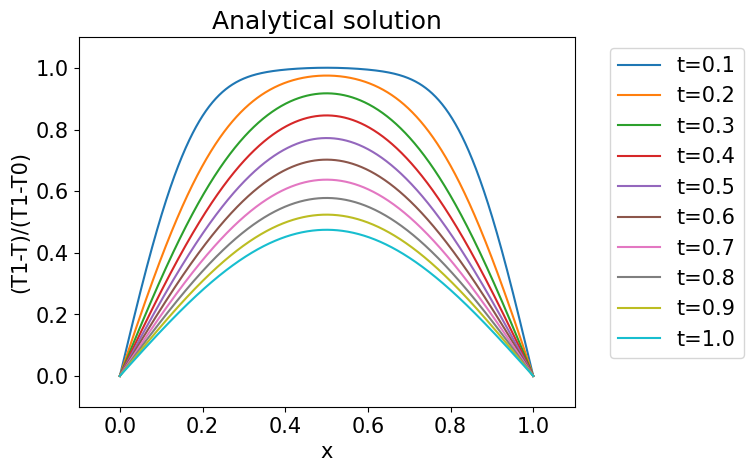

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def Fx(H, x, t):
    """
    Computes the analytical solution of the heat equation at a given time `t` and spatial points `x`.
    
    Parameters:
    - H (float): The characteristic length of the spatial domain.
    - x (array-like): The spatial points at which the solution is evaluated.
    - t (float): The time at which the solution is evaluated.
    
    Returns:
    - Fx (array-like): The analytical solution of the heat equation at the given spatial points and time.
    """
    # Calculate the analytical solution of the heat equation using the series expansion
    Fx = 4 / np.pi * (np.exp(-1 * np.pi**2 * alpha * t / (4 * H**2)) * np.sin(np.pi * x / (2 * H)) +
                      1 / 3 * np.exp(-9 * np.pi**2 * alpha * t / (4 * H**2)) * np.sin(3 * np.pi * x / (2 * H)) +
                      1 / 5 * np.exp(-25 * np.pi**2 * alpha * t / (4 * H**2)) * np.sin(5 * np.pi * x / (2 * H)))
    return Fx

# Define the spatial domain and time points for plotting
x = np.linspace(xmin, xmax, 1000)  # Generate 1000 points between minx and maxx for plotting
for t in range(1, 11):  # Loop over time steps from 0.1 to 1.0 in increments of 0.1
    ti = t / 10  # Convert integer time step to float time value
    plt.plot(x, Fx(H, x, ti), label='t=' + str(ti))  # Plot the analytical solution at each time step

# Customize the plot
plt.title('Analytical solution')  # Set the title of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place the legend outside the plot to the right
plt.xlabel('x')  # Label the x-axis
plt.ylabel('(T1-T)/(T1-T0)')  # Label the y-axis, normalized temperature
plt.xlim(-0.1, 1.1)  # Set the limits for the x-axis
plt.ylim(-0.1, 1.1)  # Set the limits for the y-axis

# Display the plot
plt.show()


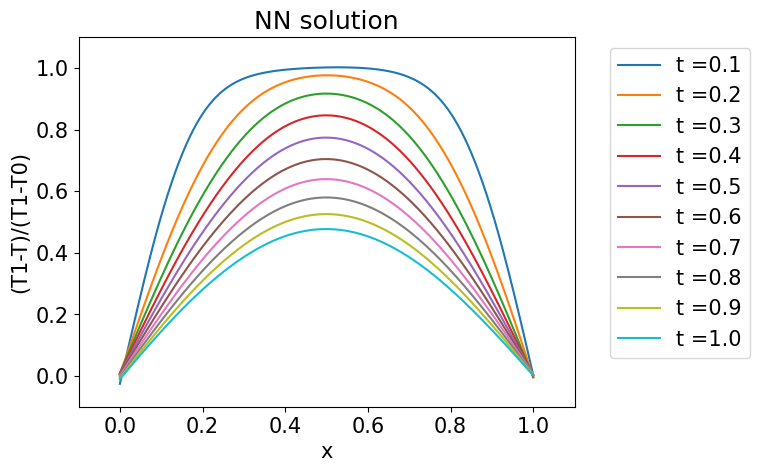

In [12]:
# Define the range of time steps for plotting
for t in range(1, 11):  # Loop from t = 1 to 10
    ti = t / 10  # Convert integer t to float time step (0.1, 0.2, ..., 1.0)

    # Create a tensor to hold spatial and time points for the current time step
    points_plot = torch.zeros(1000, 2)  # Tensor of shape (1000, 2) to store x and t values
    points_plot[:, 0] = torch.linspace(0, 1, 1000) * (xmax - xmin) + xmin  # Spatial points from minx to maxx
    points_plot[:, 1] = ti  # Set all time values to ti

    # Define boundary temperature values
    T1 = 60  # Upper boundary temperature
    T0 = 50  # Lower boundary temperature

    # Compute the neural network's predictions for the current time step
    F_x_ti = PINN(points_plot.to(device)).cpu()  # Get predictions from the PINN model and move to CPU

    x = points_plot[:, 0]  # Extract the spatial points from the tensor

    # Normalize the predictions using the boundary temperatures
    F_plot = (T1 - F_x_ti) / (T1 - T0)  # Normalize to the range [0, 1]

    # Plot the normalized solution for the current time step
    plt.plot(x.detach().numpy(), F_plot.detach().numpy(), label='t =' + str(ti))

# Customize the plot
plt.title('NN solution')  # Set the title of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place the legend outside the plot to the right
plt.xlabel('x')  # Label the x-axis
plt.ylabel('(T1-T)/(T1-T0)')  # Label the y-axis with normalized temperature
plt.xlim(-0.1, 1.1)  # Set the limits for the x-axis
plt.ylim(-0.1, 1.1)  # Set the limits for the y-axis
# Display the plot
plt.show()


In [15]:
# Loop over time steps from 0 to 1 in increments of 0.1
for t in range(11):  # Includes t = 0 through t = 10
    ti = t / 10  # Convert integer t to float time step (0.0, 0.1, ..., 1.0)
    
    # Create a tensor to hold spatial and time points
    points_plot = torch.zeros(1000, 2)  # Tensor of shape (1000, 2) to store x and t values
    points_plot[:, 0] = torch.linspace(xmin, xmax, 1000)  # Generate 1000 evenly spaced x values between minx and maxx
    points_plot[:, 1] = ti  # Set all time values to the current time step ti

    # Compute the neural network's predictions for the current time step
    F_x_ti = PINN(points_plot.to(device)).cpu()  # Get predictions from the PINN model and move to CPU

    # Normalize the predictions using boundary temperatures
    F_plot = (T1 - F_x_ti) / (T1 - T0)  # Normalize the predictions to the range [0, 1]

    # Generate spatial points for analytical solution computation
    x = np.linspace(xmin, xmax, 1000)  # Create 1000 evenly spaced x values for analytical solution
    # Compute the analytical solution at the current time step
    Anal_sol = Fx(H, x, ti)

    # Compute the mean squared error between the neural network solution and the analytical solution
    S = 0
    for i in range(len(F_x_ti)):
        # Sum of squared differences between the neural network and analytical solutions
        S += (F_plot[i].item() - Anal_sol[i]) ** 2
    mean_error = S / len(F_x_ti)  # Mean squared error

    # Print the mean error for the current time step
    print('ti =', ti, 'mean error =', mean_error)


ti = 0.0 mean error = 0.04987928828506008
ti = 0.1 mean error = 6.631107566153354e-05
ti = 0.2 mean error = 1.256627856592459e-05
ti = 0.3 mean error = 7.239648782590061e-06
ti = 0.4 mean error = 9.244050764788542e-06
ti = 0.5 mean error = 9.76689176658881e-06
ti = 0.6 mean error = 7.163816512078453e-06
ti = 0.7 mean error = 4.798242816738976e-06
ti = 0.8 mean error = 4.277502246839702e-06
ti = 0.9 mean error = 5.341834824649329e-06
ti = 1.0 mean error = 7.831423921443168e-06
